In [41]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary


import re
import numpy as np
from nltk.corpus import stopwords


from razdel import tokenize


import pymorphy2 

from gensim.models import LdaModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

%matplotlib inline

In [4]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [5]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [14]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [15]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [16]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [17]:
%%time

news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-16-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 29.6 s


In [19]:
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

In [20]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [22]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [23]:
%%time
from gensim.models import LdaModel

lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 40 s


In [24]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(7, 0.054408684),
 (9, 0.26574272),
 (10, 0.42316937),
 (17, 0.17532212),
 (22, 0.063454114)]

In [25]:
x = lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic) + " ".join(words))

topic_0: население операция температура район регион это который
topic_1: смерть планета болезнь группа умереть год медицина
topic_2: активность доклад бизнесмен виза лёд экспериментальный направлять
topic_3: километр граница израиль белоруссия остаток транспорт таможенный
topic_4: украина киев определение реформа украинец компьютер рада
topic_5: столетие молдавия ежедневный молдавский разобрать telegraphn весёлый
topic_6: год россия который это российский страна nn
topic_7: польша годовой германия италия звание южный сократиться
topic_8: выяснить врач страдать писать теория девочка больной
topic_9: это который компания мочь человек год исследование
topic_10: год это nn который первый время весь
topic_11: фонд научный исследование медведев японский дыра энергетика
topic_12: взрыв космос египет воздух помещение атмосферный nn
topic_13: остров океан япония японец хабаровский аргентина тщательный
topic_14: человек рак погибнуть кровь канал память который
topic_15: рейс предмет конкурс сол

In [26]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [27]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.041236,0.0,0.000000,0.000000,0.0,0.875427,0.0,0.075645,0.000000,0.0
1,4896,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.109015,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,4897,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.054294,0.0,...,0.000000,0.0,0.175378,0.000000,0.0,0.000000,0.0,0.063592,0.000000,0.0
3,4898,0.032592,0.0,0.0,0.0,0.0,0.0,0.0,0.074037,0.0,...,0.371649,0.0,0.034804,0.279097,0.0,0.000000,0.0,0.000000,0.096269,0.0
4,4899,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.134125,0.000000,0.0,0.840280,0.0,0.000000,0.000000,0.0


### Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [28]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [29]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [47]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # ИЗМЕНЕНИЯ
    user_vector = np.median(user_vector, 0)
    # ИЗМЕНЕНИЯ
    return user_vector

In [48]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.23018496, 0.        , 0.        , 0.        ,
       0.01814636, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.34093691, 0.09310238,
       0.07105656, 0.        , 0.        , 0.        , 0.01369873])

In [49]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.174024,0.0,0.0,...,0.0,0.000000,0.0,0.066691,0.143407,0.041875,0.000000,0.0,0.000000,0.000000
1,u108690,0.030738,0.027713,0.0,0.0,0.023451,0.0,0.229686,0.0,0.0,...,0.0,0.037041,0.0,0.244791,0.067965,0.078659,0.026473,0.0,0.000000,0.008738
2,u108339,0.048188,0.000000,0.0,0.0,0.000000,0.0,0.361624,0.0,0.0,...,0.0,0.026290,0.0,0.070204,0.078432,0.094641,0.000000,0.0,0.014964,0.010529


In [50]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [51]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.174024,0.0,0.0,...,0.000000,0.0,0.066691,0.143407,0.041875,0.000000,0.0,0.000000,0.000000,0
1,u108690,0.030738,0.027713,0.0,0.0,0.023451,0.0,0.229686,0.0,0.0,...,0.037041,0.0,0.244791,0.067965,0.078659,0.026473,0.0,0.000000,0.008738,1
2,u108339,0.048188,0.000000,0.0,0.0,0.000000,0.0,0.361624,0.0,0.0,...,0.026290,0.0,0.070204,0.078432,0.094641,0.000000,0.0,0.014964,0.010529,1


In [52]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [53]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [54]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.39075909, 0.13650871, 0.26667506, 0.13200508, 0.07663726,
       0.06434043, 0.10416391, 0.06752172, 0.04672725, 0.13812441])

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.231705, F-Score=0.654, Precision=0.552, Recall=0.804


In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1595  160]
 [  49  196]]


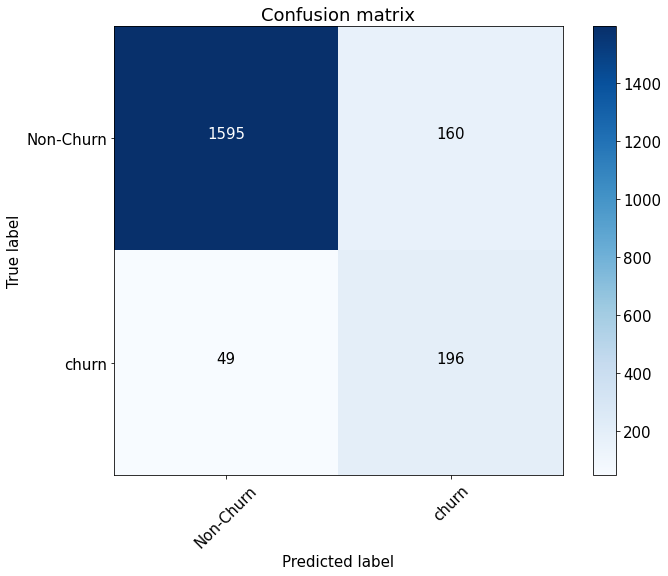

In [57]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [58]:
roc_auc_score(y_test, preds)

0.9351450665736379

### Повторить п.2, но используя уже не медиану, а max

In [59]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # ИЗМЕНЕНИЯ
    user_vector = np.max(user_vector, 0)
    # ИЗМЕНЕНИЯ
    return user_vector

In [60]:
get_user_embedding(user_articles_list)

array([0.03557678, 0.04651097, 0.        , 0.        , 0.        ,
       0.        , 0.84008819, 0.03383093, 0.06339774, 0.08353771,
       0.20065844, 0.        , 0.        , 0.06268266, 0.02551535,
       0.03648624, 0.02692409, 0.        , 0.41331744, 0.28712708,
       0.35429561, 0.0130528 , 0.        , 0.05486395, 0.18979834])

In [61]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.068396,0.027466,0.0,0.017264,0.09381,0.0,0.410602,0.0,0.000000,...,0.036492,0.097997,0.0,0.437907,0.288785,0.558234,0.037724,0.052068,0.082325,0.033254
1,u108690,0.061673,0.044360,0.0,0.000000,0.08114,0.0,0.394664,0.0,0.025187,...,0.121315,0.065112,0.0,0.468122,0.154971,0.294286,0.038813,0.034449,0.022667,0.120062
2,u108339,0.224483,0.055885,0.0,0.000000,0.00000,0.0,0.436031,0.0,0.093170,...,0.017175,0.125895,0.0,0.197711,0.141957,0.338402,0.014566,0.044411,0.091572,0.074430


In [62]:
X_1 = pd.merge(user_embeddings, target, 'left')
X_1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.068396,0.027466,0.0,0.017264,0.09381,0.0,0.410602,0.0,0.000000,...,0.097997,0.0,0.437907,0.288785,0.558234,0.037724,0.052068,0.082325,0.033254,0
1,u108690,0.061673,0.044360,0.0,0.000000,0.08114,0.0,0.394664,0.0,0.025187,...,0.065112,0.0,0.468122,0.154971,0.294286,0.038813,0.034449,0.022667,0.120062,1
2,u108339,0.224483,0.055885,0.0,0.000000,0.00000,0.0,0.436031,0.0,0.093170,...,0.125895,0.0,0.197711,0.141957,0.338402,0.014566,0.044411,0.091572,0.074430,1


In [63]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X_1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_1['churn'], random_state=0)

In [64]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [65]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.26264639, 0.00440886, 0.59865878, 0.04519329, 0.07253036,
       0.12533924, 0.21341591, 0.12016811, 0.0012093 , 0.06010917])

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380317, F-Score=0.732, Precision=0.770, Recall=0.698


In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1704   51]
 [  75  170]]


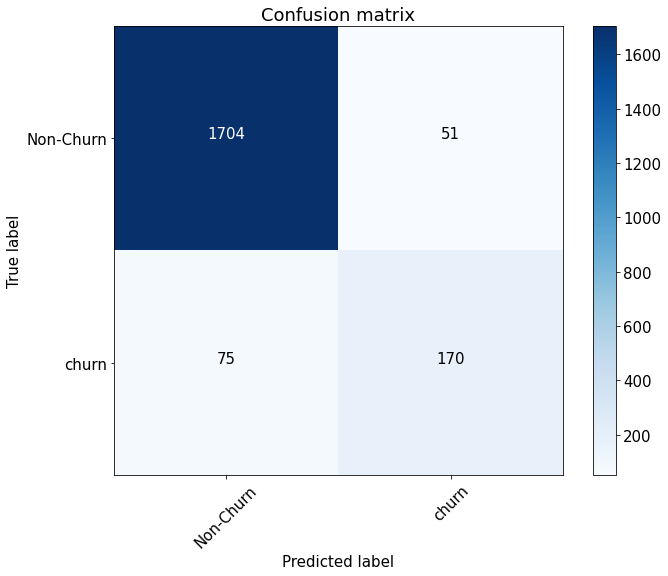

In [68]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [69]:
roc_auc_score(y_test, preds)

0.9531949531949532